In [38]:
import numpy as np
import pandas as pd
import openml


from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.calibration import CalibratedClassifierCV, calibration_curve, CalibrationDisplay
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import log_loss, accuracy_score, brier_score_loss, roc_auc_score


import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import seaborn as sns

from venn_abers import VennAbersCalibrator, VennAbers

from crepes import WrapClassifier, ConformalClassifier

from nonconformist.nc import NcFactory, InverseProbabilityErrFunc, MarginErrFunc
from nonconformist.cp import TcpClassifier


import warnings
warnings.filterwarnings('ignore')




# from collections import Counter


In [39]:
# dataset

dataset_id = 31 # German Credit Data
dataset = openml.datasets.get_dataset(dataset_id)
X, y, _, _ = dataset.get_data(target=dataset.default_target_attribute)

# handle datatypes
# convert categorical data to numerical
category_columns = X.select_dtypes(include=['category']).columns
label_encoders = {}
for column in category_columns:
    label_encoders[column] = LabelEncoder()
    X[column] = label_encoders[column].fit_transform(X[column])
# convert uint8 to int
uint8_columns = X.select_dtypes(include=['uint8']).columns
for column in uint8_columns:
    X[column] = X[column].astype('int')
# convert class labels to numerical
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)


# standardize the data
scaler = StandardScaler()
X[uint8_columns] = scaler.fit_transform(X[uint8_columns])
X[['credit_amount']] = scaler.fit_transform(X[['credit_amount']])

# display dataset
display(X.head(5))
print("class labels:", label_encoder.classes_)
print("class distribution:", np.bincount(y))

# train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


,checking_status,duration,credit_history,purpose,credit_amount,savings_status,employment,installment_commitment,personal_status,other_parties,residence_since,property_magnitude,age,other_payment_plans,housing,existing_credits,job,num_dependents,own_telephone,foreign_worker
0,1,-1.236478,1,6,-0.745131,4,3,0.918477,3,2,1.046987,3,2.766456,1,1,1.027079,1,-0.428290,1,1
1,0,2.248194,3,6,0.949817,2,0,-0.870183,0,2,-0.765977,3,-1.191404,1,1,-0.704926,1,-0.428290,0,1
2,3,-0.738668,1,2,-0.416562,2,1,-0.870183,3,2,0.140505,3,1.183312,1,1,-0.704926,3,2.334869,0,1
3,1,1.750384,3,3,1.634247,2,1,-0.870183,3,1,1.046987,1,0.831502,1,0,-0.704926,1,2.334869,0,1
4,1,0.256953,2,4,0.566664,2,0,0.024147,3,2,1.046987,2,1.535122,1,0,1.027079,1,2.334869,0,1


class labels: ['bad' 'good']
class distribution: [300 700]


## Nonconformist Library

In [71]:
# model
clf = RandomForestClassifier(n_estimators=100, random_state=42)

nc = NcFactory.create_nc(clf, err_func=InverseProbabilityErrFunc())
tcp = TcpClassifier(nc)
tcp.fit(X_train, y_train)
predictions = tcp.predict(X_test.values, significance=0.1)

Coverage: 0.880
Average Set Width: 1.23


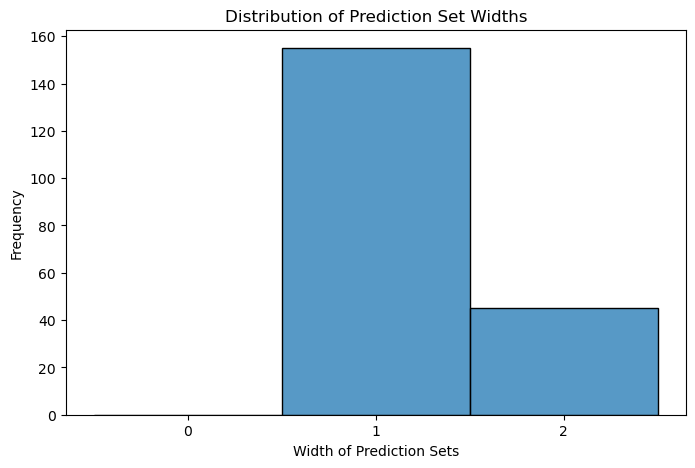

In [73]:
# evaluation
coverage = np.mean([predictions[i][y_test[i]] for i in range(len(y_test))])
widths = [np.sum(pred) for pred in predictions]
average_width = np.mean(widths)

print(f"Coverage: {coverage:.3f}")
print(f"Average Set Width: {average_width:.2f}")

# Plot distribution of predictive set sizes
plt.figure(figsize=(8, 5))
sns.histplot(widths, bins=np.arange(0, 4) - 0.5, edgecolor='black', kde=False)
plt.xticks([0, 1, 2])
plt.xlabel('Width of Prediction Sets')
plt.ylabel('Frequency')
plt.title('Distribution of Prediction Set Widths')
# plt.grid(True)
plt.show()

## Crepes Library

In [74]:
# dataset
# create calibration set
X_train_proper, X_cal, y_train_proper, y_cal = train_test_split(X_train, y_train, test_size=0.2)

In [75]:
# model
clf = RandomForestClassifier(n_estimators=100, random_state=42)
wrapped_clf = WrapClassifier(clf)

wrapped_clf.fit(X_train_proper, y_train_proper)
wrapped_clf.calibrate(X_cal, y_cal)

prediction_sets = wrapped_clf.predict_set(X_test, confidence=0.9)
predictions = wrapped_clf.predict(X_test)

# print(prediction_sets)
# print(prediction_sets.shape)

In [76]:
# evaluation
coverage = np.mean([prediction_sets[i][y_test[i]] for i in range(len(y_test))])
widths = [np.sum(pred) for pred in prediction_sets]
average_width = np.mean(widths)

print(f"Coverage: {coverage:.2f}")
print(f"Average Set Width: {average_width:.2f}")

wrapped_clf.evaluate(X_test, y_test, confidence=0.9)

Coverage: 0.92
Average Set Width: 1.39


{'error': 0.07999999999999996,
 'avg_c': 1.39,
 'one_c': 0.61,
 'empty': 0.0,
 'time_fit': 0.0,
 'time_evaluate': 0.017412900924682617}

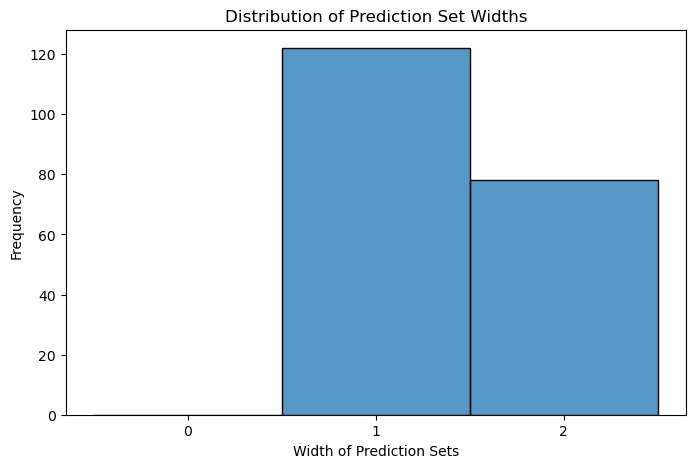

In [77]:
# Plot distribution of predictive set sizes
plt.figure(figsize=(8, 5))
sns.histplot(widths, bins=np.arange(0, 4) - 0.5, edgecolor='black', kde=False)
plt.xticks([0, 1, 2])
plt.xlabel('Width of Prediction Sets')
plt.ylabel('Frequency')
plt.title('Distribution of Prediction Set Widths')
# plt.grid(True)
plt.show()

#### Mondrian conformal classifiers Class-conditional

In [78]:
# model
clf = RandomForestClassifier(n_estimators=100, random_state=42)
wrapped_clf = WrapClassifier(clf)
wrapped_clf.fit(X_train_proper, y_train_proper)

rf_class_cond = WrapClassifier(wrapped_clf.learner)
wrapped_clf = rf_class_cond
wrapped_clf.calibrate(X_cal, y_cal, class_cond=True)

prediciton_sets = wrapped_clf.predict_set(X_test, confidence=0.9)
predictions = wrapped_clf.predict(X_test)

# print(prediciton_sets[:5])
# print(prediciton_sets.shape)


In [79]:
# evaluation
coverage = np.mean([prediction_sets[i][y_test[i]] for i in range(len(y_test))])
widths = [np.sum(pred) for pred in prediction_sets]
average_width = np.mean(widths)

print(f"Coverage: {coverage:.2f}")
print(f"Average Set Width: {average_width:.2f}")

wrapped_clf.evaluate(X_test, y_test, confidence=0.9)

Coverage: 0.92
Average Set Width: 1.39


{'error': 0.06000000000000005,
 'avg_c': 1.635,
 'one_c': 0.365,
 'empty': 0.0,
 'time_fit': 0.0,
 'time_evaluate': 0.030863523483276367}

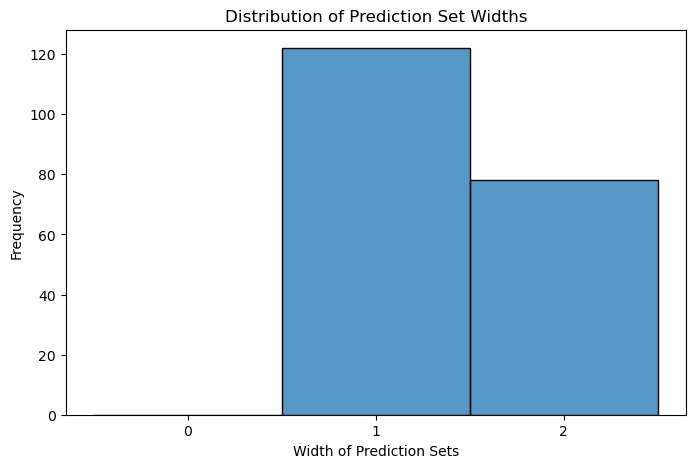

In [80]:
# Plot distribution of predictive set sizes
plt.figure(figsize=(8, 5))
sns.histplot(widths, bins=np.arange(0, 4) - 0.5, edgecolor='black', kde=False)
plt.xticks([0, 1, 2])
plt.xlabel('Width of Prediction Sets')
plt.ylabel('Frequency')
plt.title('Distribution of Prediction Set Widths')
# plt.grid(True)
plt.show()

## Venn Abers Library

In [40]:
# model
clf = RandomForestClassifier(n_estimators=100, random_state=42)
va = VennAbersCalibrator(estimator=clf, inductive=True, cal_size=0.2, shuffle=False)
va.fit(X_train, y_train)
va_inductive_prob = va.predict_proba(X_test)
va_inductive_pred = va.predict(X_test)
predictions = va_inductive_pred
prediction_prob = va_inductive_prob

print(predictions[:5])
print(y_test[:5])
print(prediction_prob[:5])
print(prediction_prob.shape)


[[0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]]
[0 1 1 1 1]
[[0.35294118 0.64705882]
 [0.40000001 0.59999999]
 [0.74999999 0.25000001]
 [0.40000001 0.59999999]
 [0.06521737 0.93478263]]
(200, 2)


In [42]:
# evaluation
predictions = np.argmax(va_inductive_prob, axis=1)
accuracy = accuracy_score(y_test, predictions)

print(f"Accuracy: {accuracy:.2f}")

Accuracy: 0.76


##  Predictor: Inductive Venn-ABERS
####  ROC AUC 0.80845


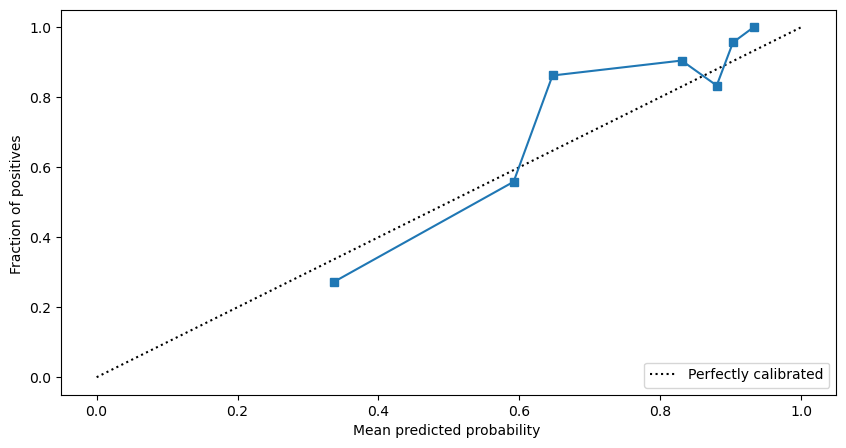

In [43]:
# plot prediction probabilities
predictions = [prediction_prob[:, 1],
              ]

prediction_names = ["Inductive Venn-ABERS",
              ]

for name, y_prob in enumerate(predictions):
    print('##  Predictor: ' + prediction_names[name] )
    # display(Markdown('####  Brier score ' + round(brier_score_loss(y_test, y_prob),5).astype("str") ))
    # display(Markdown('####  Log loss ' + round(log_loss(y_test, y_prob),5).astype("str") ))
    print('####  ROC AUC ' + round(roc_auc_score(y_test, y_prob),5).astype("str") )


    prob_true, prob_pred = calibration_curve(y_test, y_prob, n_bins=10, strategy='quantile')
    
    fig, (ax1) = plt.subplots(1, 1, figsize=(10, 5))
    CalibrationDisplay(prob_true, prob_pred, y_prob).plot(ax=ax1)
    plt.show()


In [31]:
# model
clf = RandomForestClassifier(n_estimators=100, random_state=42)
va = VennAbersCalibrator(estimator=clf, inductive=False, n_splits=5, shuffle=False)
va.fit(X_train, y_train)
va_cross_prob = va.predict_proba(X_test)
va_cross_pred = va.predict(X_test)
predictions = va_cross_pred
prediction_prob = va_cross_prob

print(predictions[:5])
print(y_test[:5])
print(prediction_prob[:5])
print(prediction_prob.shape)


[[0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]]
[0 1 1 1 1]
[[0.23602313 0.76397687]
 [0.35922207 0.64077793]
 [0.77675968 0.22324032]
 [0.46090508 0.53909492]
 [0.07539748 0.92460252]]
(200, 2)


In [36]:
# evaluation
predictions = np.argmax(va_cross_prob, axis=1)
accuracy = accuracy_score(y_test, predictions)

print(f"Accuracy: {accuracy:.2f}")

Accuracy: 0.79


##  Predictor: Cross Venn-ABERS
####  ROC AUC 0.81182


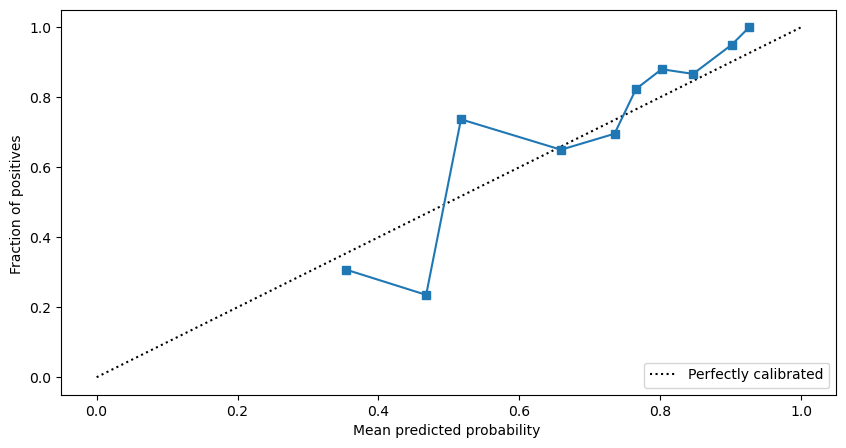

In [37]:
# plot prediction probabilities
predictions = [prediction_prob[:, 1],
              ]

prediction_names = ["Cross Venn-ABERS",
              ]

for name, y_prob in enumerate(predictions):
    print('##  Predictor: ' + prediction_names[name] )
    # display(Markdown('####  Brier score ' + round(brier_score_loss(y_test, y_prob),5).astype("str") ))
    # display(Markdown('####  Log loss ' + round(log_loss(y_test, y_prob),5).astype("str") ))
    print('####  ROC AUC ' + round(roc_auc_score(y_test, y_prob),5).astype("str") )


    prob_true, prob_pred = calibration_curve(y_test, y_prob, n_bins=10, strategy='quantile')
    
    fig, (ax1) = plt.subplots(1, 1, figsize=(10, 5))
    CalibrationDisplay(prob_true, prob_pred, y_prob).plot(ax=ax1)
    plt.show()
